In [ ]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *

from mkit.torch_support.nn_utils import training_loop


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
files = get_files("../data")
return_list = []
file = files[0]
path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']
WIDTH, HEIGHT

original dataset size: 238
dataset size with duplicates removed: 172


(48, 64)

In [ ]:
tol_num = labels.shape[0]
test_num  = int(tol_num * .2)
train_num = tol_num - test_num
np.random.shuffle(labels)
train_labels = labels[:train_num]
test_labels = labels[-train_num:]

In [ ]:
def get_list(labels):
    x_list = []
    y_list = []
    y_seq_list = []
    y_one_hot_list = []
    y_label_list = []
    for observation in labels:
        unique_values = np.unique(observation)[1:]
        if len(unique_values) == 1: continue
        unique_values = np.sort(unique_values)

        half = len(unique_values) // 2
        x = deepcopy(observation)
        y = deepcopy(observation)
        y_seq = []
        y_one_hot = deepcopy(observation)
        y_one_hot[np.where(y_one_hot != 0)] = 1
        y_label = np.zeros((MAX_LEN, observation.shape[0], observation.shape[1] + 1))

        count = 0
        for idx, val in enumerate(unique_values):
            index = np.where(observation == val)
            coor = encoder.single_transform(tuple([index[0][0], index[1][0]]))
            if val > half:
                x[index] = 0
                y_seq.append(coor)
                y_label[count][index] = 1    
                count += 1
            else:
                
                x[index] = 1
                y_one_hot[index] = 0
                y[index] = 0
        for i in range(count, MAX_LEN):
            y_label[i][0, 0] = 1
        y = y / max(unique_values)
        y_seq += [0] * (MAX_LEN - len(y_seq))

        y_one_hot = y_one_hot.flatten()
        x_list.append(x)
        y_list.append(y)
        y_one_hot_list.append(y_one_hot)
        y_seq_list.append(y_seq)
        y_label_list.append(y_label.reshape(MAX_LEN, -1))
    return x_list, y_list, y_seq_list, y_one_hot_list, y_label_list
x_list, y_list, y_seq_list, y_one_hot_list, y_label_list = get_list(train_labels)


In [ ]:
# from mkit.torch_support.tensor_utils import xy_to_tensordataset
# loader, val_loader = xy_to_tensordataset(
#     np.expand_dims(np.array(x_list), 1), np.array(y_one_hot_list),
#     return_loader=True, 
#     batch_size=8,
#     input_dtype=torch.float32,
#     output_dtype=torch.float32,
#     test_ratio=.15
# )

In [199]:
from mkit.torch_support.tensor_utils import xy_to_tensordataset
loader, val_loader, test_loader = xy_to_tensordataset(
    np.expand_dims(np.array(x_list), 1), np.array(y_label_list),
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
    test_ratio=.15
)

In [200]:
s_x, s_y = next(iter(loader))
s_x.shape, s_y.shape

(torch.Size([8, 1, 48, 64]), torch.Size([8, 7, 3120]))

In [ ]:
import torch
from torch import nn, optim
from tqdm import tqdm
from torch_geometric.data import Data

# ----------------------------
# Conditional Generator: Segmentation from Image and Noise
# ----------------------------
class ConditionalSegmentationGenerator(nn.Module):
    def __init__(self, latent_dim, width, height, max_len, img_channels=1, feature_maps=64, device=None):
        """
        Generator that takes an input image and a latent noise vector, then produces a segmentation mask.
        The output is of shape (batch, max_len, height, width), where max_len is the number of segmentation channels.
        """
        super(ConditionalSegmentationGenerator, self).__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Encoder: downsample the input image.
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, kernel_size=3, stride=2, padding=1),  # -> (feature_maps, H/2, W/2)
            nn.BatchNorm2d(feature_maps, affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=3, stride=2, padding=1),  # -> (feature_maps*2, H/4, W/4)
            nn.BatchNorm2d(feature_maps * 2, affine=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Calculate encoded feature dimensions
        self.enc_channels = feature_maps * 2
        self.enc_h = height // 4
        self.enc_w = width // 4
        self.enc_dim = self.enc_channels * self.enc_h * self.enc_w

        # Fully connected layer that projects the concatenated [encoded image, noise] vector 
        # to an initial feature map for the decoder.
        self.init_h = height // 16  # e.g., if height=64, then init_h=4.
        self.init_w = width // 16
        self.init_channels = feature_maps * 8  # Adjust as needed.
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + self.enc_dim, self.init_channels * self.init_h * self.init_w),
            nn.LeakyReLU()
        )
        
        # Decoder: Upsample from the bottleneck to the final segmentation mask.
        # NOTE: The final ConvTranspose2d now outputs max_len channels directly.
        self.decoder = nn.Sequential(
            # Upsample 1: from (init_channels, init_h, init_w) to (feature_maps*4, H/8, W/8)
            nn.ConvTranspose2d(self.init_channels, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4, affine=False),
            nn.LeakyReLU(),
            # Upsample 2: to (feature_maps*2, H/4, W/4)
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2, affine=False),
            nn.LeakyReLU(),
            # Upsample 3: to (feature_maps, H/2, W/2)
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps, affine=False),
            nn.LeakyReLU(),
            # Upsample 4: to (max_len, H, W) – the segmentation mask with max_len channels
            nn.ConvTranspose2d(feature_maps, max_len, kernel_size=4, stride=2, padding=1),
        )
        self.to(self.device)
    
    def forward(self, img, z):
        """
        img: condition image tensor of shape (batch, img_channels, height, width)
        z: latent noise tensor of shape (batch, latent_dim)
        
        Returns:
          seg_mask: segmentation mask of shape (batch, max_len, height, width)
        """
        img = img.to(self.device)
        z = z.to(self.device)
        # Encode the condition image.
        enc = self.encoder(img)  # (batch, enc_channels, H/4, W/4)
        enc_flat = enc.view(enc.size(0), -1)  # (batch, enc_dim)
        # Concatenate encoded image features with noise.
        combined = torch.cat([enc_flat, z], dim=1)
        fc_out = self.fc(combined)
        batch_size = img.size(0)
        fc_out = fc_out.view(batch_size, self.init_channels, self.init_h, self.init_w)
        # Decode to obtain the segmentation mask.
        seg_mask = self.decoder(fc_out)  # (batch, max_len, height, width)
        seg_mask = seg_mask.transpose(2, 3)
        return seg_mask

# ----------------------------
# Conditional Discriminator: Jointly Evaluate Image and Segmentation Mask
# ----------------------------
class ConditionalSegmentationDiscriminator(nn.Module):
    def __init__(self, width, height, img_channels=1, seg_channels=1, start_dim=64, number_of_layers=3, device=None):
        """
        The discriminator takes as input the condition image and a segmentation mask,
        concatenated along the channel dimension. It outputs a single logit indicating real or fake.
        """
        super(ConditionalSegmentationDiscriminator, self).__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # The input has (img_channels + seg_channels) channels.
        input_channels = img_channels + seg_channels
        layers = []
        current_dim = start_dim
        layers.append(self._block(input_channels, current_dim))
        for _ in range(number_of_layers - 1):
            layers.append(self._block(current_dim, current_dim * 2))
            current_dim *= 2
        layers.append(nn.Flatten())
        # flattened_size assumes the spatial dimensions remain constant.
        flattened_size = width * height * current_dim
        layers.append(nn.Linear(flattened_size, 1))  # Single output logit per sample.
        self.net = nn.Sequential(*layers)
        self.to(self.device)
    
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, affine=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, img, mask):
        """
        img: condition image of shape (batch, img_channels, height, width)
        mask: segmentation mask of shape (batch, seg_channels, height, width)
        """
        img = img.to(self.device)
        mask = mask.to(self.device)
        # Concatenate along the channel dimension.
        x = torch.cat([img, mask], dim=1)
        validity = self.net(x)
        return validity

# ----------------------------
# GAN Training Loop for Conditional Segmentation
# ----------------------------
def train_conditional_segmentation_gan(
    generator, discriminator,
    dataloader, n_epochs,
    seg_criterion,   # e.g. nn.BCEWithLogitsLoss for segmentation
    latent_dim,
    lambda_adv=0.001,  # Weight for adversarial loss in generator loss
    device=None,
    max_len=None,  # max_len now equals the number of segmentation channels
):
    """
    For each batch:
      - The generator takes a condition image and a noise vector, and produces a segmentation mask.
      - A segmentation loss (comparing the generated mask to the ground truth mask) is computed.
      - An adversarial loss is computed using the discriminator.
      - The discriminator is trained to differentiate between real and generated (fake) mask-image pairs.
    
    Ground truth masks are expected as flattened vectors of length width*height*max_len, which are reshaped to (batch, max_len, height, width)
    before feeding to the discriminator.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer_G = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))
    
    adversarial_loss = nn.BCEWithLogitsLoss().to(device)
    
    # Label smoothing for real labels
    label_smoothing = 0.9

    for epoch in range(n_epochs):
        d_avg_loss = 0
        adv_avg_loss = 0
        seg_avg_loss = 0
        for i, (imgs, true_masks) in enumerate(tqdm(dataloader)):
            # imgs: (batch, img_channels, height, width)
            # true_masks: ground truth segmentation masks as flattened vectors of shape (batch, height*width*max_len)
            batch_size = imgs.size(0)
            imgs = imgs.to(device)
            true_masks = true_masks.to(device)
            
            # Reshape ground truth masks to (batch, max_len, height, width)
            _, _, height, width = imgs.shape
            real_mask_img = true_masks.view(batch_size, max_len, height, width)
            
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            # Sample latent noise
            z = torch.randn(batch_size, latent_dim, device=device)
            # Generate segmentation mask conditioned on the input image and noise.
            seg_logits = generator(imgs, z)  # (batch, max_len, height, width)
            
            # Compute segmentation loss (e.g. pixelwise BCE with logits)
            seg_loss = seg_criterion(seg_logits, real_mask_img)
            
            # For adversarial loss, get discriminator predictions.
            valid_labels = torch.full((batch_size, 1), label_smoothing, device=device)
            adv_loss = adversarial_loss(discriminator(imgs, seg_logits), valid_labels)
            
            g_loss = seg_loss + lambda_adv * adv_loss
            g_loss.backward()
            optimizer_G.step()
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            valid_labels = torch.full((batch_size, 1), label_smoothing, device=device)
            valid_loss = adversarial_loss(discriminator(imgs, real_mask_img), valid_labels)
            fake_labels = torch.zeros((batch_size, 1), device=device)
            fake_loss = adversarial_loss(discriminator(imgs, seg_logits.detach()), fake_labels)
            d_loss = (valid_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            adv_avg_loss += adv_loss.item() / len(dataloader)
            d_avg_loss += d_loss.item() / len(dataloader)
            seg_avg_loss += seg_loss.item() / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{n_epochs}] "
              f"D loss: {d_avg_loss:.4f} | "
              f"G adv loss: {adv_avg_loss:.4f} | "
              f"G seg loss: {seg_avg_loss:.4f}")
    
    return generator, discriminator

# ----------------------------
# Example Usage
# ----------------------------
# Define dimensions and hyperparameters:
IMG_CHANNELS = 1       # e.g. Grayscale images (change if using RGB).
N_EPOCHS = 500
LATENT_DIM = 400       # Dimensionality of noise vector
FEATURE_MAPS = 32      # Base number of feature maps

# WIDTH, HEIGHT, and MAX_LEN should be defined (e.g., image width/height and number of segmentation channels)
# For example:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ConditionalSegmentationGenerator(
    latent_dim=LATENT_DIM,
    width=WIDTH,
    height=HEIGHT,
    max_len=MAX_LEN,
    img_channels=IMG_CHANNELS,
    feature_maps=FEATURE_MAPS,
    device=device
)
# Note: Pass seg_channels=MAX_LEN to the discriminator.
discriminator = ConditionalSegmentationDiscriminator(
    width=WIDTH,
    height=HEIGHT,
    img_channels=IMG_CHANNELS,
    seg_channels=MAX_LEN,
    start_dim=32,
    number_of_layers=3,
    device=device
)

# Use BCEWithLogitsLoss for segmentation (pixelwise classification)
segmentation_loss_fn = nn.BCEWithLogitsLoss().to(device)

# Your DataLoader should provide tuples:
#   - imgs: (batch, img_channels, HEIGHT, WIDTH)
#   - true_masks: (batch, HEIGHT*WIDTH*MAX_LEN) with values in [0,1]
# For example:
#   loader = torch.utils.data.DataLoader(your_dataset, batch_size=8, shuffle=True)

# Train the GAN:
generator, discriminator = train_conditional_segmentation_gan(
    generator, discriminator,
    dataloader=loader,
    n_epochs=N_EPOCHS,
    seg_criterion=segmentation_loss_fn,
    latent_dim=LATENT_DIM,
    lambda_adv=0.001,
    device=device,
    max_len=MAX_LEN
)


In [159]:
generator

z = torch.randn(1, LATENT_DIM, device=device)

[2880 2613 3008 2815 1215    1 2680]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1727    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1215    1    0]
[2880 2613 3008 2815 1215    1    0]


C:\Users\ss348\AppData\Local\Temp\ipykernel_19216\1651359289.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Counter({(44, 63): 20,
         (40, 52): 20,
         (46, 63): 20,
         (43, 62): 20,
         (18, 62): 10,
         (0, 0): 20,
         (41, 55): 1,
         (26, 62): 10})

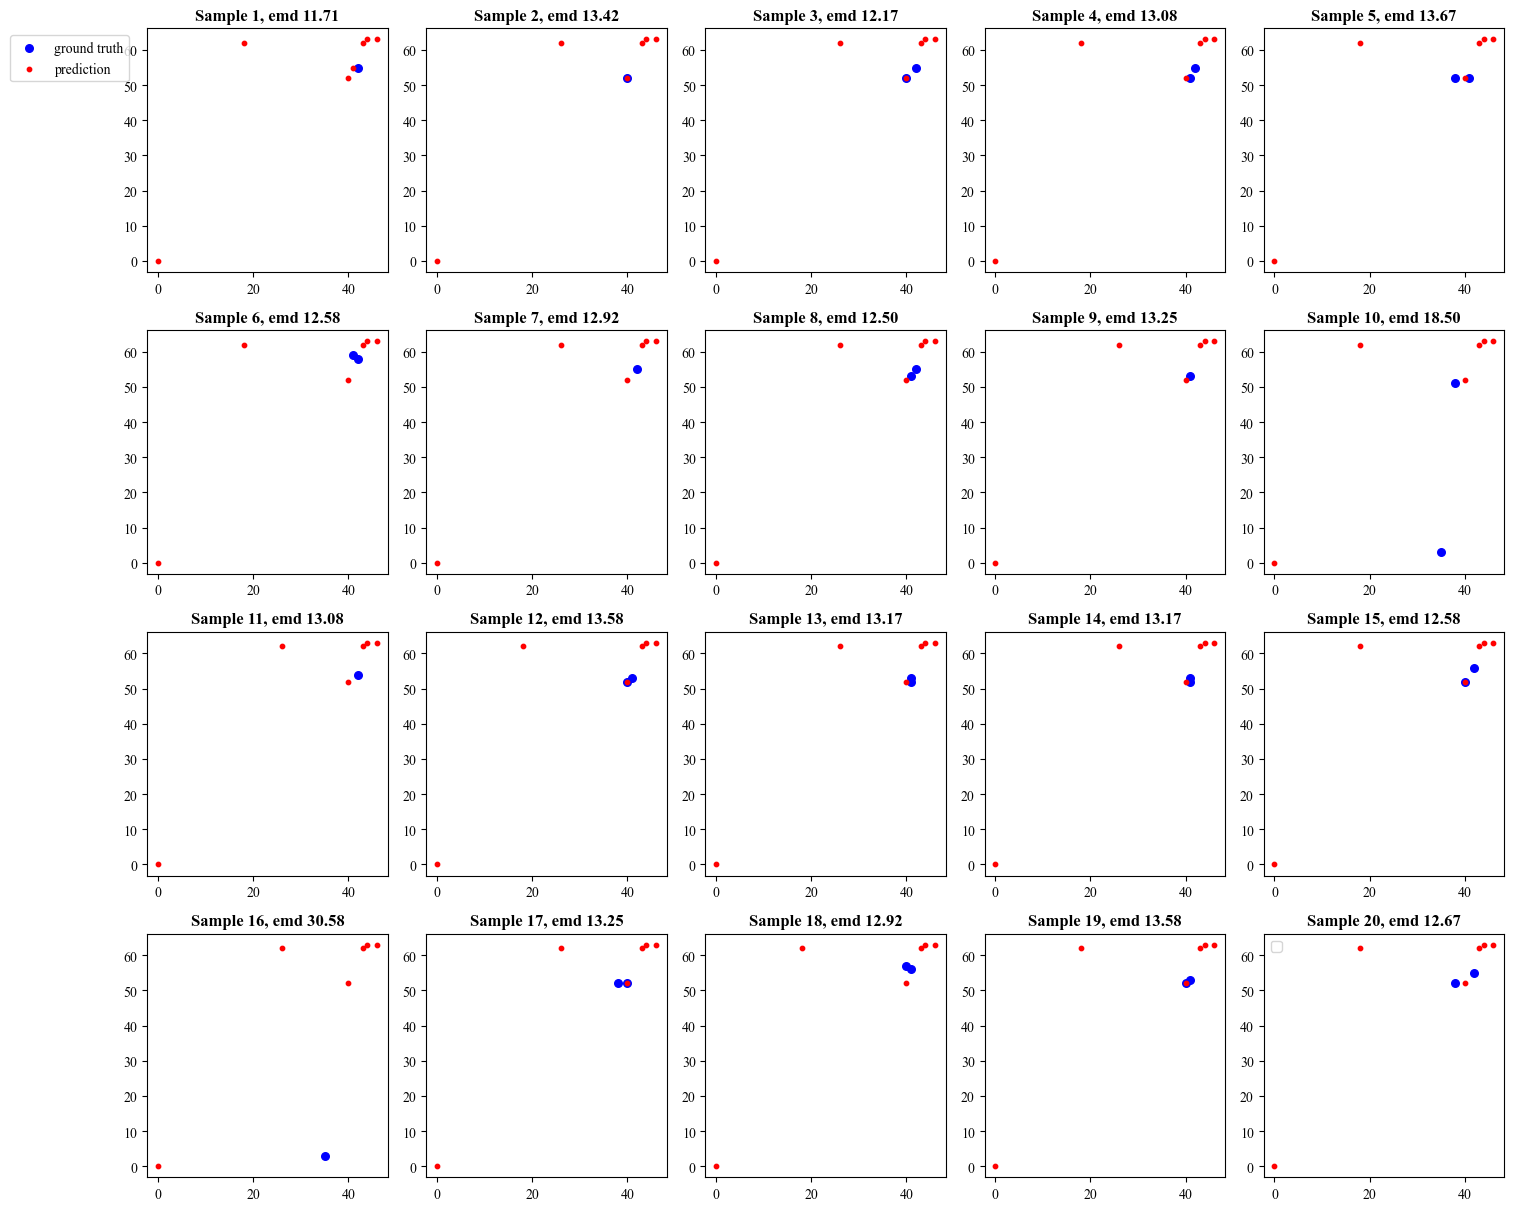

In [ ]:

from scipy.stats import wasserstein_distance

def jaccard_sim(pred, truth):
    pred_set = set(pred)
    truth_set = set(truth)
    return len(pred_set & truth_set) / len(pred_set | truth_set)

plt.rcParams["font.family"] = "Times New Roman"
jc_list = []
emd_list = []
total_number_of_samples = test_loader.dataset.__len__()
cols = 5
rows = (total_number_of_samples // cols) + 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

axes = axes.flatten()
counter = Counter()

for i, (test_x, test_y) in enumerate(test_loader.dataset):
    ax = axes[i]
        
    z = torch.randn(test_x.size(0), LATENT_DIM, device=device)
    test_x = test_x.to(generator.device)
    test_x = test_x.unsqueeze(0)
    truth = np.array(np.where(test_y == 1)).T[:, 1:].reshape(-1)
         
    raw_pred = generator(test_x, z)[0]
    truth = truth[truth.nonzero()]
    pred = torch.argmax(raw_pred.reshape(raw_pred.size(0), -1), dim=1)
          
    pred = pred.cpu().detach().numpy()
    pred = pred[pred.nonzero()]
    # jc_score = 1- jaccard_sim(pred.tolist(), truth.tolist())
    pred = encoder.transform(pred.tolist(), inverse=True)
    truth = encoder.transform(truth.tolist(), inverse=True)

    truth_np = np.array(truth)
    pred_np = np.array(pred)
          
    counter.update([tuple(ele) for ele in pred_np])

    ax.scatter(truth_np[:, 0], truth_np[:, 1], c='blue', s=30
                , label='ground truth' if i ==0 else None)
    ax.scatter(pred_np[:, 0], pred_np[:, 1], c='red', s=10, 
                label='prediction' if i ==0 else None)
    emd_x = wasserstein_distance(pred_np[:, 0], truth_np[:, 0])
    emd_y = wasserstein_distance(pred_np[:, 1], truth_np[:, 1])
    emd = (emd_x + emd_y) / 2
    ax.set_title(f"Sample {i+1}, emd {emd:.2f}", 
                 fontsize=12, fontweight='bold')
    emd_list.append(emd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
if total_number_of_samples > 0:
    axes[0].legend(loc='upper left', bbox_to_anchor=(-.6, 1))
plt.tight_layout()
plt.legend()
counter